In [73]:
from matplotlib import pyplot as plt
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from models import conv_relu, train
from dataset import load_dataset
from visualization import classes_to_image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
def show_example(y, prediction):
    plt.subplot(1, 2, 1)
    plt.title('Reference marking')
    plt.axis('off')
    plt.imshow(classes_to_image(np.array(y)))
    
    plt.subplot(1, 2, 2)
    plt.title('Model output')
    plt.axis('off')
    plt.imshow(classes_to_image(np.array(prediction)))
    
    plt.show()

In [93]:
d = load_dataset("dataset.hdf5")

In [176]:
m = conv_relu(d.input_bands, d.output_bands, n_filters=16, layers=5)

In [188]:
loss_history = train(m, d.train, 1e-4, epochs=1)

Epoch 1
Iteration 0, loss=199.1642608642578, acc=0.8322715759277344, fractions: 0.8363761901855469 0.16147613525390625 0.002147674560546875
Iteration 10, loss=11.746387481689453, acc=0.9904365539550781, fractions: 0.9904365539550781 0.008472442626953125 0.00109100341796875
Iteration 20, loss=18.462963104248047, acc=0.9953346252441406, fractions: 0.9980964660644531 0.001171112060546875 0.000732421875
Iteration 30, loss=3.0800278186798096, acc=0.9988288879394531, fractions: 0.9991989135742188 0.000457763671875 0.00034332275390625
Iteration 40, loss=17.067611694335938, acc=0.9964141845703125, fractions: 0.9991569519042969 0.000545501708984375 0.00029754638671875


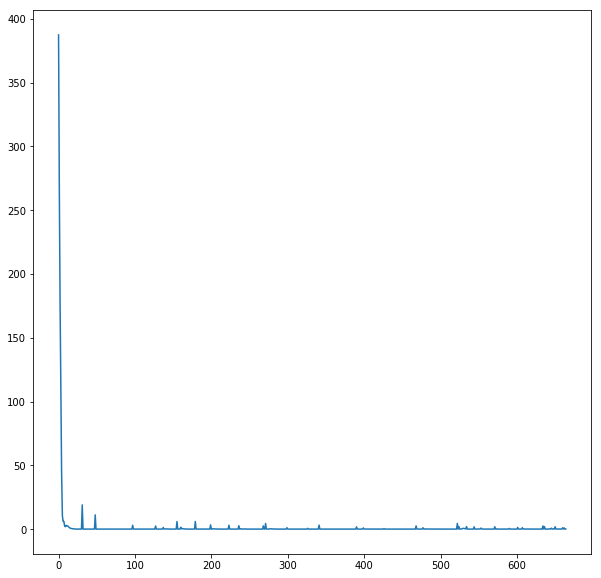

In [179]:
plt.plot(loss_history)

In [152]:
loss_history[-1]

0.15975435078144073

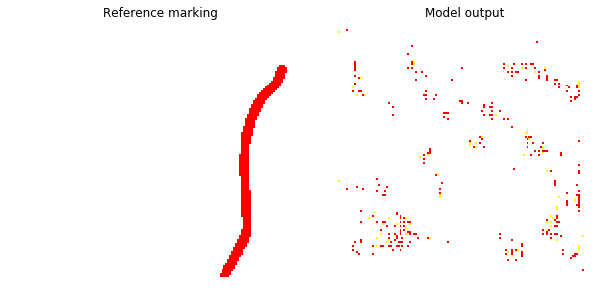

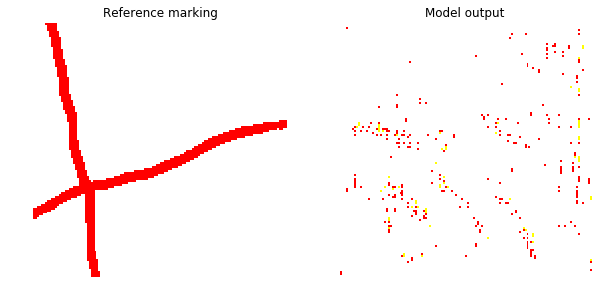

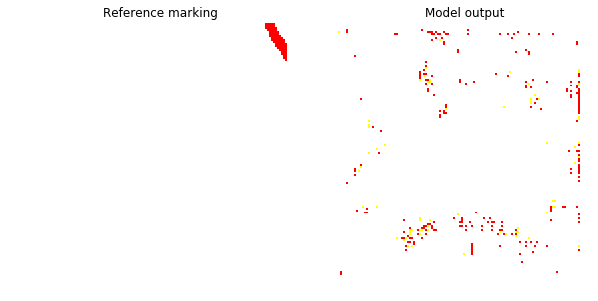

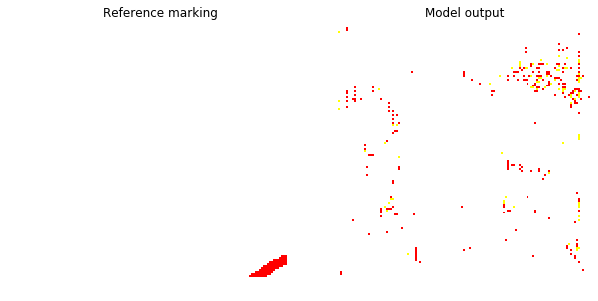

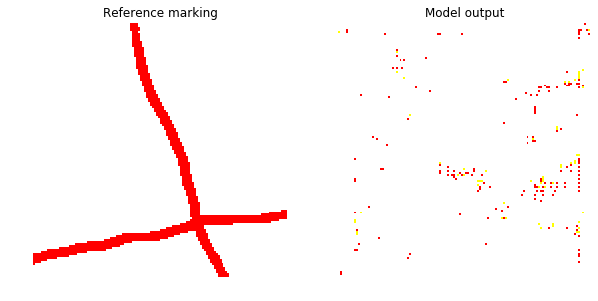

In [181]:
EXAMPLES = 5

while EXAMPLES > 0:
    idx = np.random.randint(0, len(d.val))
    (x, y) = d.train[idx]
    
    if (np.array(y).argmax(axis=0) == 1).sum() == 0:
        continue
      
    prediction = to_numpy(m(x.reshape(1, x.shape[0], x.shape[1], x.shape[2]).to(dtype=torch.float32)))[0]
    show_example(y, prediction)
    EXAMPLES -= 1